<a href="https://colab.research.google.com/github/aswa09/EVA-4/blob/master/S12/EVA4_S12_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

'dogs_coco.json' - JSON File Structure:

The annotation file is a JSON COCO format file, and with the below contents:

- images:

  - id: Image id
  - width: Width of the image
  - height: Height of the image
  - filename: Image file name
  - license: License id for the image
  - date_captured: Date of capture of the image


- annotations:

  - id: Annotation id
  - image_id: Id of the image the annotation is associated with
  - category_id: Id of the class the annotation belongs to
  - segmentation: (x, y) coordinates of the four corners of the bounding box
  - area: Area of the bounding box
  - bbox: (x, y) coordinate of the top-left corner and width and height of the bounding box
  - iscrowd: If the image has a crowd of objects denoted by this annotation

##Import Libraries

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import json
import os
from sklearn.cluster import KMeans
import numpy as np

##Mount Drive

In [2]:
from google.colab import drive

drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [3]:
os.chdir('./drive/My Drive/Colab Notebooks/S12/datasets/dogs/')

!ls

anchor_bbox_k3.png   cluster_plot_k4.png  dogs_csv.csv	  kmeans_iou.png
cluster_plot_k3.png  dogs_coco.json	  dogs_json.json


##Parse the JSON file for annotations

In [4]:
def load_json(path):
    with open(path) as f:
        img_annotations = eval(f.read())
    return img_annotations

##Get datapoints from annotations 

In [5]:
def get_datapoints(img_annotations):
    """
    Args:
      img_annotations (dict): Image annotations.
    Returns:
      Array containing data points.
    """

    data_points = []
    for annotation in img_annotations['annotations']:
        bbox = annotation['bbox']
        img = img_annotations['images'][int(annotation['image_id'])-1]

        # Norm height and width of bbox
        data_points.append((
            bbox[2] / img['width'],
            bbox[3] / img['height']
        ))
    return np.array(data_points)

##K-Means Clustering

In [6]:
def get_kmeans(data_points,k):
  kmeans = KMeans(n_clusters=k, random_state=0).fit(data_points)
  centroids=kmeans.cluster_centers_

  distances = np.sqrt(((data_points - centroids[:, np.newaxis]) ** 2).sum(axis=2))
  closest = np.argmin(distances, axis=0)

  return centroids,closest,kmeans

##Function to get IOU

In [7]:
def get_iou(centroids,closest,data_points):
  """Calculate Intersection over Union (IoU) for each point with its closest centroid."""
  closest_centroids = centroids[closest]
  width = np.minimum(closest_centroids[:, 0], data_points[:, 0])
  height = np.minimum(closest_centroids[:, 1], data_points[:, 1])

  intersection = width * height
  points_area = data_points[:, 0] * data_points[:, 1]
  cluster_area = closest_centroids[:, 0] * closest_centroids[:, 1]

  mean_iou = np.mean(intersection / (points_area + cluster_area - intersection))
  return mean_iou

Visualize Results
Display the Number of clusters vs Mean IoU graph

In [8]:
def plot_k_iou(iou_list):
  plt.cla
  plt.clf()
  
  fig = plt.figure(figsize=(9, 5))

  plt.plot(iou_list, '-s')

  plt.xlabel('Number of Clusters(k)')
  plt.ylabel('Mean IoU')

  plt.xticks(np.arange(len(iou_list)), np.arange(1, len(iou_list)+1))
  plt.title('Number of Clusters(k) vs Mean IoU')

  fig.savefig('kmeans_iou.png')

In [9]:
def get_cluster_number():
  img_annotations = load_json('dogs_coco.json')
  data_points = get_datapoints(img_annotations)

  # Visualize Data
  # height vs width of normalized bounding boxes

  plt.scatter(data_points[:, 0], data_points[:, 1])
  plt.xlabel('width')
  plt.ylabel('height')
  plt.title('width vs height')
  plt.show()

  iou_list = []

  #Range of clusters to use
  nclusters_start = 1
  nclusters_end = 16

  for k in range(nclusters_start, nclusters_end + 1):
      centroids,closest,kmeans=get_kmeans(data_points,k)
      iou_list.append(get_iou(centroids,closest,data_points))

  plot_k_iou(iou_list)

  return data_points

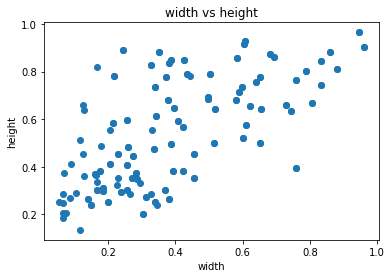

<Figure size 432x288 with 0 Axes>

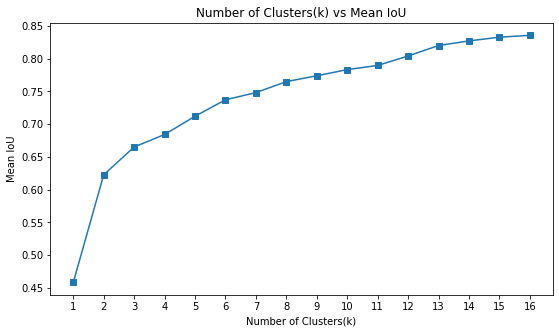

In [10]:
data_points=get_cluster_number()

####From the graph we can see that k = 3 or k = 4 appear to be optimal cluster numbers, as the curve tends to be linear after k=4

##Plotting the clusters for k=3 and 4

In [16]:
def display_clusters(kmeans,data_points):
    num_clusters = kmeans.n_clusters

    #clusters
    for cluster_id in range(num_clusters):
      distances = np.sqrt(((data_points - centroids[:, np.newaxis]) ** 2).sum(axis=2))
      closest = np.argmin(distances, axis=0)

      points = data_points[closest == cluster_id]
      plt.scatter(points[:, 0], points[:, 1])
  
    #centroids
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black',marker='x')
    plt.xlabel('width')
    plt.ylabel('height')
    plt.title(f'Cluster Plot for k='+str(num_clusters))
    plt.show()
    plt.savefig(f'cluster_plot_k'+str(num_clusters)+'.png')

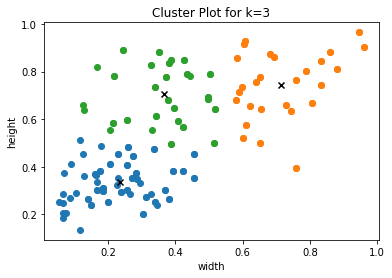

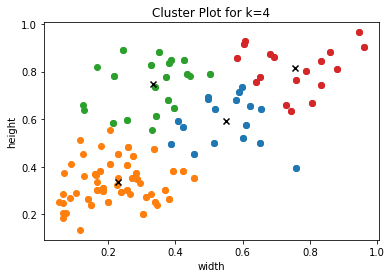

<Figure size 432x288 with 0 Axes>

In [17]:
#k=3
centroids,closest,kmeans=get_kmeans(data_points,3)
display_clusters(kmeans,data_points)

#k=4
centroids,closest,kmeans=get_kmeans(data_points,4)
display_clusters(kmeans,data_points)

Plot Anchor Boxes
Plot the anchor boxes obtained for k = 3 and k = 4

In [13]:
def make_anchor_boxes(ax, clusters, edgecolor='b', alpha=1):
    """Make anchorboxes for given cluster centroids."""

    xdata = np.array([0.5]*len(clusters))
    ydata = np.array([0.5]*len(clusters))

    xerror = np.array([list(np.exp(clusters[:, 0])/2)]*2)
    yerror = np.array([list(np.exp(clusters[:, 1])/2)]*2)

    errorboxes = []

    #get box from errors at each point
    for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
        rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
        errorboxes.append(rect)

    pc = PatchCollection(errorboxes, facecolor='None', alpha=alpha, edgecolor=edgecolor)
    ax.add_collection(pc)

    # Plot errorbars
    errorbars = ax.errorbar(xdata, ydata, xerr=xerror, yerr=yerror, fmt='None', ecolor='None')

    return errorbars

In [14]:
def plot_aboxes(kmeans,k):
  fig, ax = plt.subplots(1)

  # Create error boxes
  _ = make_anchor_boxes(ax, kmeans.cluster_centers_)

  plt.title('Anchor boxes for k='+str(k))
  plt.show()
  fig.savefig('anchor_bbox_k'+str(k)+'.png')

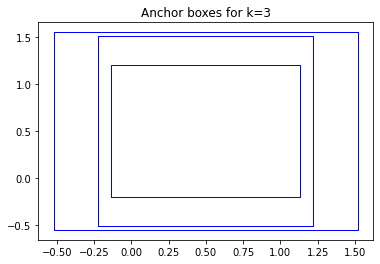

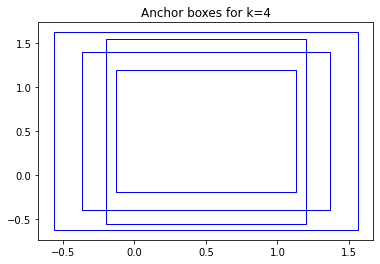

In [15]:
#k=3
centroids,closest,kmeans=get_kmeans(data_points,3)
plot_aboxes(kmeans,k=3)

#k=4
centroids,closest,kmeans=get_kmeans(data_points,4)
plot_aboxes(kmeans,k=4)